In [1]:
# Basic DS libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
from wordcloud import WordCloud

# Utility libraries
import os
from dotenv import load_dotenv
from collections import Counter
from pprint import pprint

# Load environment variables
load_dotenv(verbose=False)

True

In [7]:
# Load data
data_path = os.environ.get("RAW_DATA_PATH")
data = pd.read_csv(f"{data_path}/new_train.csv", index_col=0)
test_data = pd.read_csv(f"{data_path}/new_test.csv", index_col=0)

## Dataset Exploration

In [3]:
data.head()

,medical_specialty,transcription,labels
0,Emergency Room Reports,"REASON FOR THE VISIT:, Very high PT/INR.,HIST...",0
1,Surgery,"PREOPERATIVE DIAGNOSIS:, Acetabular fracture ...",1
2,Surgery,"NAME OF PROCEDURE,1. Selective coronary angio...",1
3,Radiology,"REFERRING DIAGNOSIS: , Motor neuron disease.,P...",2
4,Emergency Room Reports,"CHIEF COMPLAINT: , Dental pain.,HISTORY OF PRE...",0


In [8]:
test_data.head()

,transcription
0,"PAST MEDICAL CONDITION:, None.,ALLERGIES:, N..."
1,"CURRENT HISTORY:, A 94-year-old female from t..."
2,"TITLE OF PROCEDURE: ,Coronary artery bypass g..."
3,"PROCEDURE: , Bilateral L5, S1, S2, and S3 radi..."
4,"OPERATIVE PROCEDURES: , Colonoscopy and biopsi..."


In [4]:
print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columsns.\n")
print(f"Data Info:\n{data.info()})\n")
print(f"Numerical Info:\n{data.describe()})\n")
print(f"Categorical Info:\n{data.describe(include='object')})\n")

The dataset has 3969 rows and 3 columsns.

<class 'pandas.core.frame.DataFrame'>
Index: 3969 entries, 0 to 3999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  3969 non-null   object
 1   transcription      3969 non-null   object
 2   labels             3969 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 124.0+ KB
Data Info:
None)

Numerical Info:
            labels
count  3969.000000
mean     10.078609
std       9.006683
min       0.000000
25%       2.000000
50%       7.000000
75%      16.000000
max      39.000000)

Categorical Info:
       medical_specialty                                      transcription
count               3969                                               3969
unique                40                                               2255
top              Surgery  PREOPERATIVE DIAGNOSIS: , Low back pain.,POSTO...
freq                 863                

In [5]:
# Missing Values
print(f"Missing values per column:\n{data.isnull().sum()}")

Missing values per column:
medical_specialty    0
transcription        0
labels               0
dtype: int64


In [6]:
# Duplicate values
data.duplicated().sum()

2

In [3]:
#  Drop the 2 Duplicate values
data.drop_duplicates(inplace=True)


## Features Exploration

### Label Analysis

In [8]:
n_labels = len(data["medical_specialty"].unique())
print(f"There are {n_labels} unique labels in the dataset")

There are 40 unique labels in the dataset


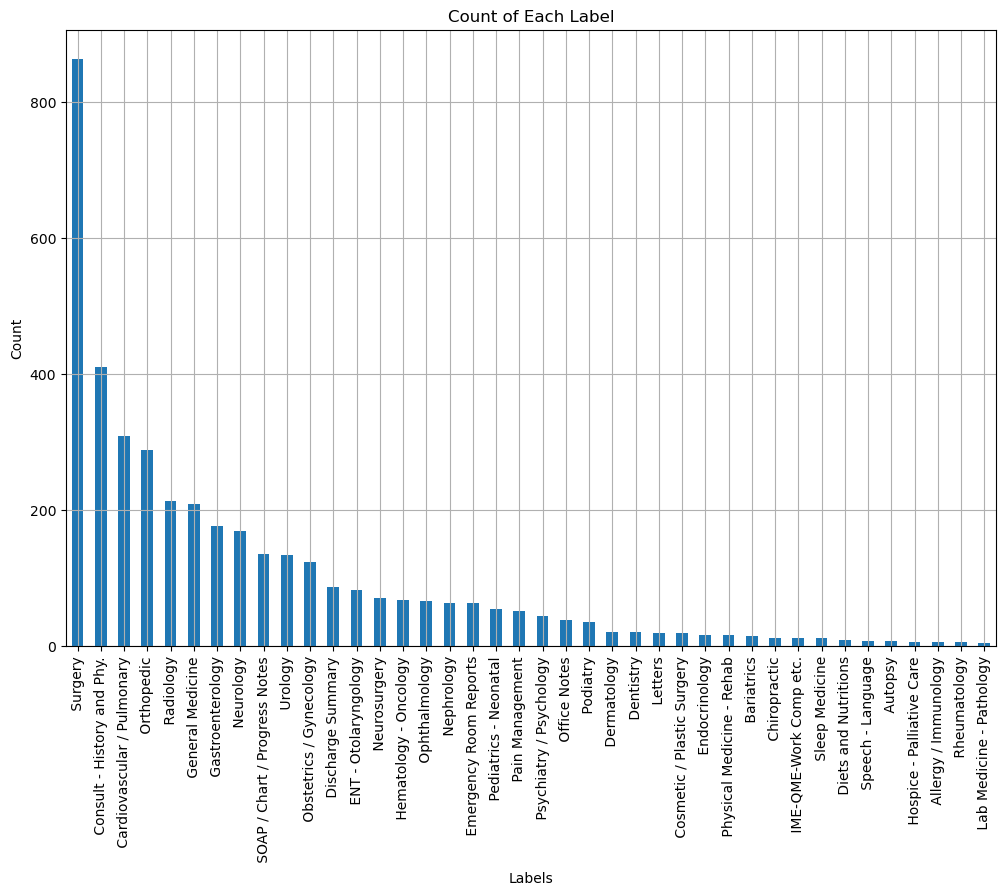

In [9]:
label_counts = data["medical_specialty"].value_counts()
plt.figure(figsize=(12, 8))
label_counts.plot(kind='bar')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Each Label')
plt.grid(True)
plt.show()

Notes:
- Vivid class imablance

### Transcription Analysis

In [10]:
# Text Sample
pprint(data["medical_specialty"][0])
pprint(data["transcription"][0][:500] + " ...")

' Emergency Room Reports'
('REASON FOR THE VISIT:,  Very high PT/INR.,HISTORY: , The patient is an '
 '81-year-old lady whom I met last month when she came in with pneumonia and '
 'CHF.  She was noticed to be in atrial fibrillation, which is a chronic '
 'problem for her.  She did not want to have Coumadin started because she said '
 'that she has had it before and the INR has had been very difficult to '
 'regulate to the point that it was dangerous, but I convinced her to restart '
 'the Coumadin again.  I gave her the Coumadin as an outpatien ...')


In [11]:
# Text Word Count Summary Statistics
transcription_lens = data['transcription'].str.split().str.len()
print(f"Summary Statistics of Transcription Length:\n{transcription_lens.describe().round(2)}")

Summary Statistics of Transcription Length:
count    3967.00
mean      467.79
std       321.77
min         1.00
25%       242.00
50%       397.00
75%       615.00
max      3029.00
Name: transcription, dtype: float64


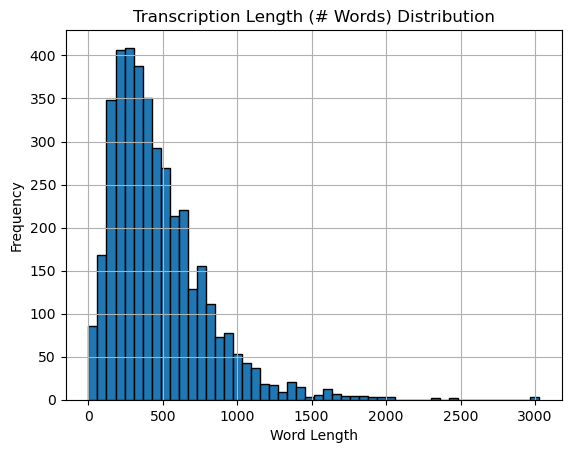

In [12]:
# Text Length Distribution
plt.hist(transcription_lens, bins=50, edgecolor='black')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Transcription Length (# Words) Distribution')
plt.grid(True)
plt.show()

In [13]:
# Create a labels:medical specialty dict
#   Ex: {0: ' Emergency Room Reports', 1: ' Surgery', ...}
labels_to_class_dict = dict(zip(data['labels'], data['medical_specialty']))
labels = list(labels_to_class_dict.keys())

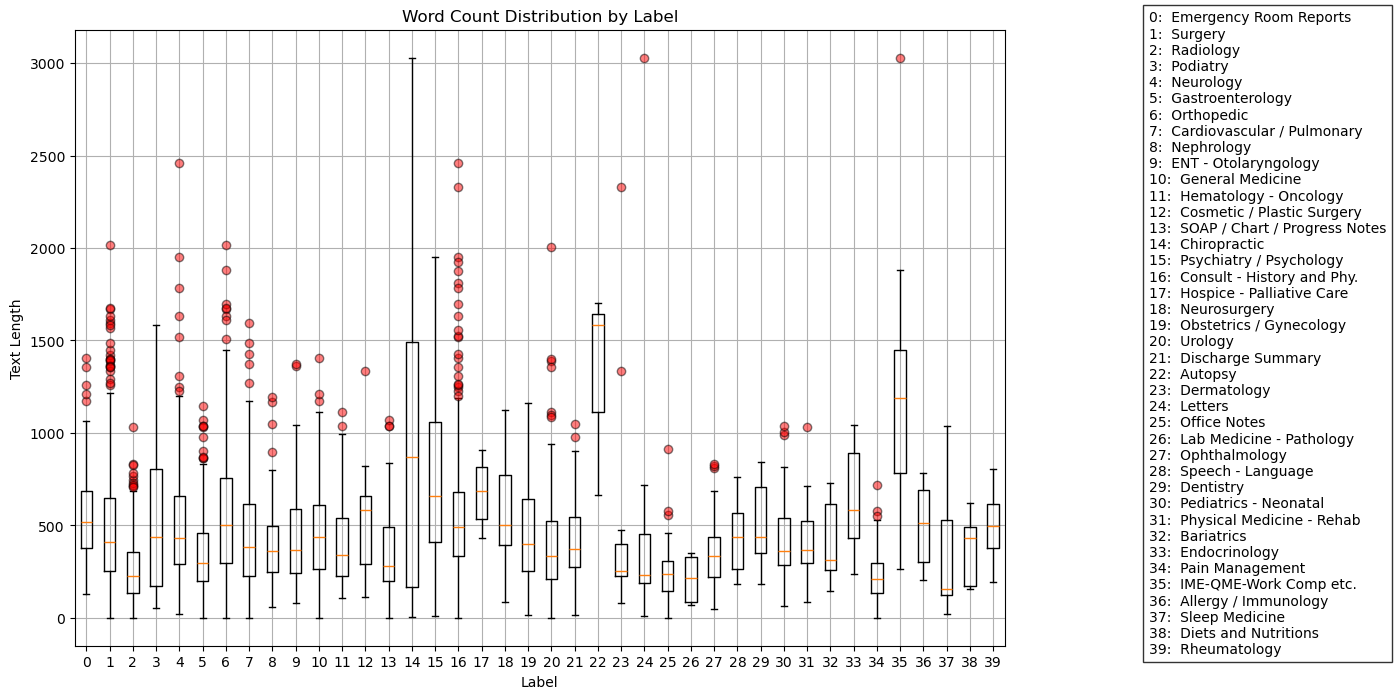

In [14]:
# Get the word count of transciption per label
word_count_per_label = [data[data['labels'] == label]['transcription'].str.split().str.len() for label in labels]
legend_text = "\n".join([f"{k}: {v}" for k, v in labels_to_class_dict.items()])

# Create boxplot for each label
plt.figure(figsize=(12, 8))
plt.boxplot(word_count_per_label, tick_labels=labels, flierprops={'markerfacecolor': 'red', 'marker': 'o', 'alpha' : 0.5})
plt.xlabel('Label')
plt.ylabel('Text Length')
plt.title('Word Count Distribution by Label')
plt.grid(True)
plt.gcf().text(1.02, 0.5, legend_text, fontsize=10, verticalalignment='center',
               bbox=dict(facecolor='white', alpha=0.8))
plt.show()



### Processed Text Exploration

In [4]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import FreqDist
from nltk.tokenize import word_tokenize

nltk.download('wordnet')

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words("english"))


# The following code can be revised / improved!
def clean_text(text):
    """Lowercase text and remove punctuation"""
    text = text.lower()
    # Replace hyphenated words (like '81-year-old') with spaces
    text = re.sub(r'(\d+)-(\w+)', r'\1 \2', text)  # Preserve hyphens between digits and words (e.g., "81-year-old" -> "81 year old")
    text = re.sub(r'(\w+)-(\w+)', r'\1 \2', text)  # Replace hyphens in general (e.g., "long-term" -> "long term")
    text = re.sub(r'\d+', '', text)
    
    # Replace other punctuation with spaces
    text = re.sub(r'/', ' ', text)  # Replace slashes with spaces
    text = re.sub(r'[:,.]', ' ', text)  # Replace colons, commas, and periods with spaces
    text = re.sub(r'[^\w\s-]', '', text)  # Remove all other punctuation except alphanumeric and hyphens
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Function to apply stemming (unused)
def stem_text(text):
    return ' '.join([stemmer.stem(word) for word in text.split()])

# Function to apply lemmatization
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Filter stopwords
def filter_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords])

def preprocess_text(text):
    text = clean_text(text)
    text = filter_stopwords(text)
    text = lemmatize_text(text)
    return text

[nltk_data] Downloading package wordnet to /Users/zaza/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
data['transcription_cleaned_simple'] = data['transcription'].apply(preprocess_text)
test_data['transcription_cleaned_simple'] = test_data['transcription'].apply(preprocess_text)

In [17]:
# Display pre-clean and post-clean differences for the first 5 samples
for i in range(2):
    print(f"Sample {i+1}:")
    print("Raw Transcription Sample:")
    pprint(data["transcription"].iloc[i][:400])
    print()
    print("Cleaned Transcription Sample:")
    pprint(data["transcription_cleaned_simple"].iloc[i][:200])
    print("-" * 80)

Sample 1:
Raw Transcription Sample:
('REASON FOR THE VISIT:,  Very high PT/INR.,HISTORY: , The patient is an '
 '81-year-old lady whom I met last month when she came in with pneumonia and '
 'CHF.  She was noticed to be in atrial fibrillation, which is a chronic '
 'problem for her.  She did not want to have Coumadin started because she said '
 'that she has had it before and the INR has had been very difficult to '
 'regulate to the point that it was da')

Cleaned Transcription Sample:
('reason visit high pt inr history patient year old lady met last month came '
 'pneumonia chf noticed atrial fibrillation chronic problem want coumadin '
 'started said inr difficult regulate point dangerous c')
--------------------------------------------------------------------------------
Sample 2:
Raw Transcription Sample:
('PREOPERATIVE DIAGNOSIS:,  Acetabular fracture on the left posterior '
 'column/transverse posterior wall variety with an accompanying displaced '
 'fracture of the intertrochan

In [18]:
# Combine all text into a single string for analysis
cleaned_all_text = ' '.join(data['transcription_cleaned_simple'])

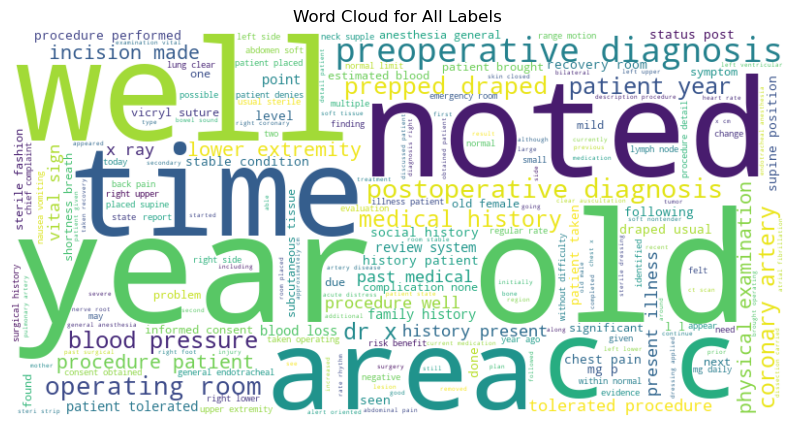

In [19]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(cleaned_all_text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for All Labels")
plt.show()

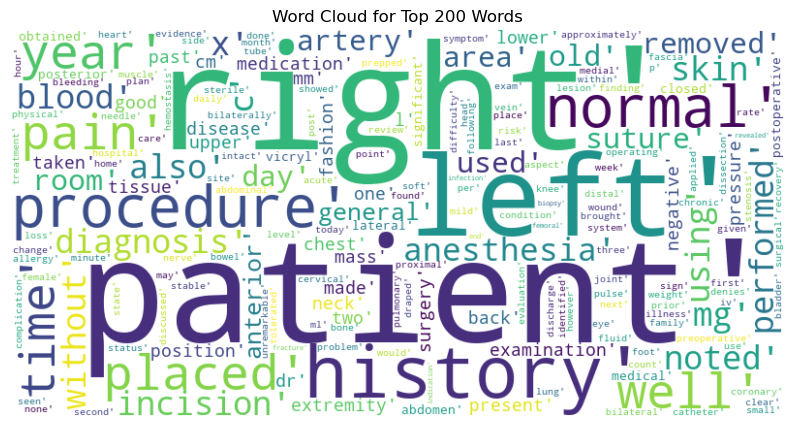

In [20]:

cleaned_all_words = cleaned_all_text.split()
top_words = Counter(cleaned_all_words).most_common(200)
wordcloud = WordCloud(width=800, height=400, max_font_size=150, background_color='white').generate(str(top_words))
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Top 200 Words")
plt.show()

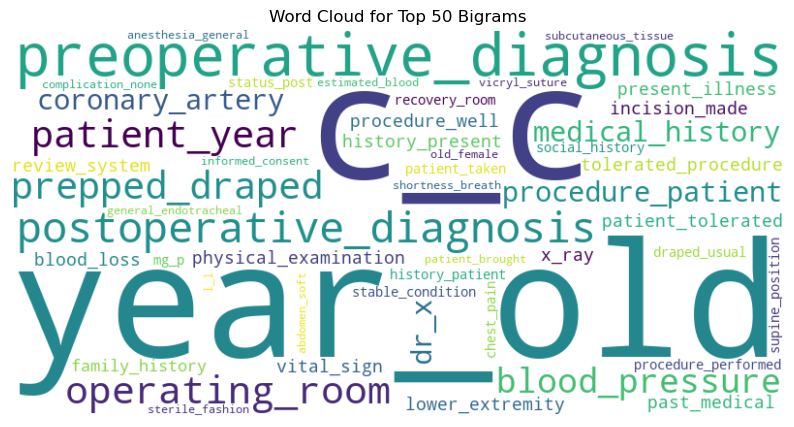

In [21]:
# Tokenize and extract bigrams
bigrams = ngrams(word_tokenize(cleaned_all_text), 2)
bigram_freq = FreqDist(bigrams)

# Get the top 50 most frequent bigrams
top_bigrams = bigram_freq.most_common(50)

# Make a word cloud for the top 10 bigrams
bigram_text = ' '.join(['_'.join(bigram) for bigram, freq in top_bigrams])
bigram_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(bigram_text)
plt.figure(figsize=(10, 8))
plt.imshow(bigram_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud for Top 50 Bigrams")
plt.show()

In [22]:

top_words_per_label = {}
for label, group in data.groupby('medical_specialty'):
    # Join all transcriptions and split into words
    all_words_per_label = ' '.join(group['transcription_cleaned_simple']).split()
    
    word_counts = Counter(all_words_per_label)
    top_words = word_counts.most_common(10)
    top_words_per_label[label] = top_words

# Print the top 5 words for each label in a clean format
for label, top_words in top_words_per_label.items():
    print(f"Label: {label}")
    for word, count in top_words[:5]:
        print(f"  Word: {word}, Count: {count}")
    print("-" * 40)


Label:  Allergy / Immunology
  Word: history, Count: 26
  Word: patient, Count: 23
  Word: noted, Count: 23
  Word: allergy, Count: 21
  Word: without, Count: 15
----------------------------------------
Label:  Autopsy
  Word: right, Count: 108
  Word: inch, Count: 91
  Word: left, Count: 83
  Word: neck, Count: 55
  Word: injury, Count: 50
----------------------------------------
Label:  Bariatrics
  Word: patient, Count: 57
  Word: history, Count: 48
  Word: also, Count: 35
  Word: surgery, Count: 29
  Word: weight, Count: 28
----------------------------------------
Label:  Cardiovascular / Pulmonary
  Word: patient, Count: 1445
  Word: left, Count: 1382
  Word: right, Count: 1135
  Word: artery, Count: 1071
  Word: procedure, Count: 622
----------------------------------------
Label:  Chiropractic
  Word: pain, Count: 169
  Word: patient, Count: 90
  Word: back, Count: 89
  Word: right, Count: 89
  Word: dr, Count: 58
----------------------------------------
Label:  Consult - Histor

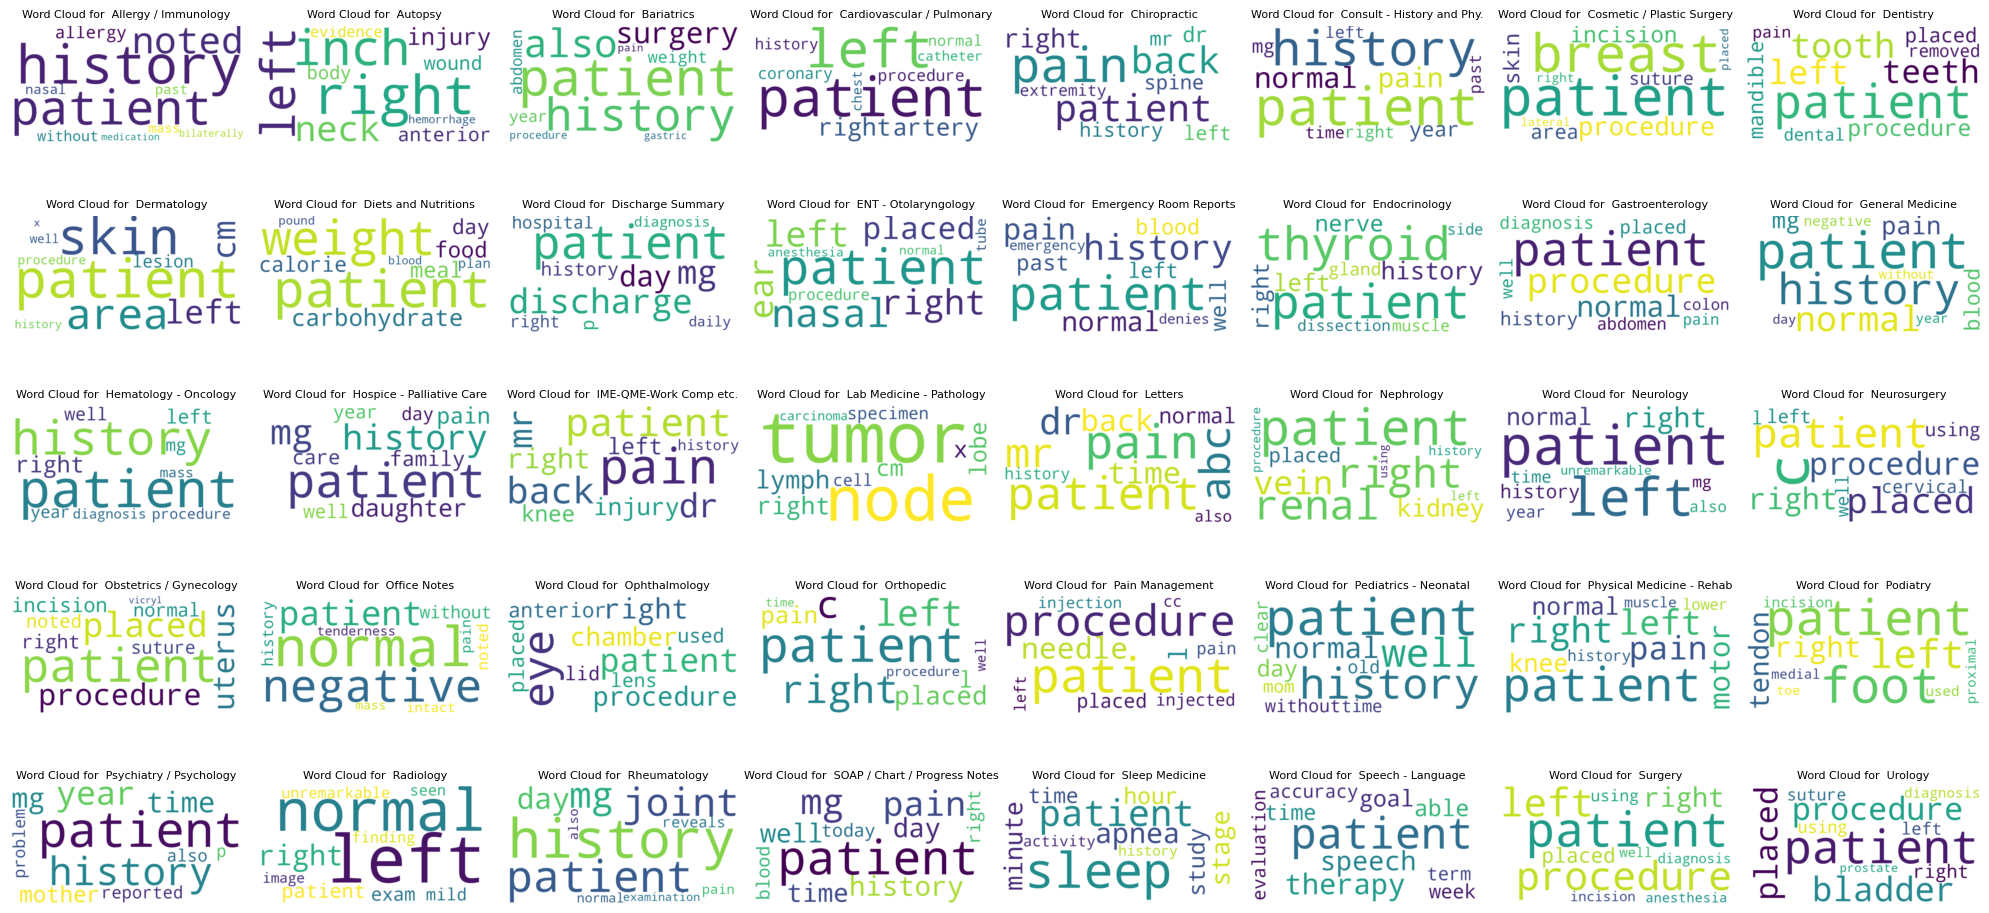

In [23]:
fig, axs = plt.subplots(5, 8, figsize=(20, 10))
axs = axs.flatten()

# Create a word cloud for each label
for ax, (label, top_words) in zip(axs, top_words_per_label.items()):
    word_frequencies = dict(top_words)
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)
    
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f"Word Cloud for {label}", fontsize=8)
plt.tight_layout()
plt.show()

# Save the Simply Processed data

In [6]:
data.head()

,medical_specialty,transcription,labels,transcription_cleaned_simple
0,Emergency Room Reports,"REASON FOR THE VISIT:, Very high PT/INR.,HIST...",0,reason visit high pt inr history patient year ...
1,Surgery,"PREOPERATIVE DIAGNOSIS:, Acetabular fracture ...",1,preoperative diagnosis acetabular fracture lef...
2,Surgery,"NAME OF PROCEDURE,1. Selective coronary angio...",1,name procedure selective coronary angiography ...
3,Radiology,"REFERRING DIAGNOSIS: , Motor neuron disease.,P...",2,referring diagnosis motor neuron disease perti...
4,Emergency Room Reports,"CHIEF COMPLAINT: , Dental pain.,HISTORY OF PRE...",0,chief complaint dental pain history present il...


In [10]:
test_data.head()

,transcription,transcription_cleaned_simple
0,"PAST MEDICAL CONDITION:, None.,ALLERGIES:, N...",past medical condition none allergy none curre...
1,"CURRENT HISTORY:, A 94-year-old female from t...",current history year old female nursing home s...
2,"TITLE OF PROCEDURE: ,Coronary artery bypass g...",title procedure coronary artery bypass graftin...
3,"PROCEDURE: , Bilateral L5, S1, S2, and S3 radi...",procedure bilateral l radiofrequency ablation ...
4,"OPERATIVE PROCEDURES: , Colonoscopy and biopsi...",operative procedure colonoscopy biopsy epineph...


In [11]:
# Save the pre-processes dataset
processed_data_path = os.environ.get("PROCESSED_DATA_PATH")
train_data_fname = "simple_cleaned_train.csv"
test_data_fname = "simple_cleaned_test.csv"

data.to_csv(f"{processed_data_path}/{train_data_fname}")
test_data.to_csv(f"{processed_data_path}/{test_data_fname}")